In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join, vstack

from tqdm import tqdm, tqdm_notebook
plt.style.use('HCH_plotstyle')

/var/folders/p2/5_2wys611fj9gl3f4r99njfw0000gn/T/ipykernel_17373/623754824.py:10: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use('HCH_plotstyle')


# Part 1: Catalog construction #

Combine the white dwarf catalog and the wide binary catalog.

Load the white dwarf catalog from Gaia EDR3 (Gentile Fusillo+2021)

In [3]:
wd_table = Table.read('../../2021_11_WDMS/0_basic_results/gaiaedr3_wd_main.fits.gz')

In [5]:
wd_table[0:10]

WDJ_name,source_id,dr2_source_id,designation,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,ZP_correction,Pwd,density,solution_id,random_index,ref_epoch,pm,pm_err,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_g_mean_mag_error,phot_g_mean_flux_corrected,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_mag_error,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_mag_error,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,phot_bp_rp_excess_factor_corrected,absG,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,excess_flux_error,bright_N_flag,meanAV,minAV,maxAV,flag_ext,teff_H,eteff_H,logg_H,elogg_H,mass_H,emass_H,chisq_H,teff_He,eteff_He,logg_He,elogg_He,mass_He,emass_He,chisq_He,teff_mixed,eteff_mixed,logg_mixed,elogg_mixed,mass_mixed,emass_mixed,chisq_mixed,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,fidelity_v1,SDSS12,sdss_clean,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,SDSS_separation,SDSS_spec
,,,,deg,mas,deg,mas,mas,mas,,,,,,,yr,mas / yr,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,'electron'.s**-1,'electron'.s**-1,,mag,mag,e-/s,mag,mag,,'electron'.s**-1,'electron'.s**-1,,mag,mag,,'electron'.s**-1,'electron'.s**-1,,mag,mag,,,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,pc,pc,pc,pc,pc,pc,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,arcsec,
bytes23,int64,int64,bytes29,float64,float32,float64,float32,float64,float32,float32,float64,float64,float64,int64,int64,float64,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,float64,float64,float64,float64,int16,float64,float32,float32,float32,float64,int16,float64,float32,float32,float32,float64,int16,int16,int16,int16,int16,float32,float64,float64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,f

Compute some WD quantities (e.g. mass) using WD models (Cheng+19)


In [7]:
import WD_models
model = WD_models.load_model(low_mass_model='Fontaine2001',
                             middle_mass_model='Renedo2010_001',
                             high_mass_model='ONe',
                             atm_type='H',
                             )

HR_grid = (-0.6, 1.5, 0.002, 8, 16, 0.01)
model = WD_models.load_model('f', 'f', 'f', 'H', HR_grid=HR_grid)
extent = (HR_grid[0], HR_grid[1], HR_grid[3], HR_grid[4])

bp_rp = wd_table['bp_rp']
G = wd_table['absG']
wd_table['tot_age'] = model['HR_to_age'](bp_rp, G)
wd_table['mass'] = model['HR_to_mass'](bp_rp, G)
wd_table['cool_age'] = model['HR_to_age_cool'](bp_rp, G)


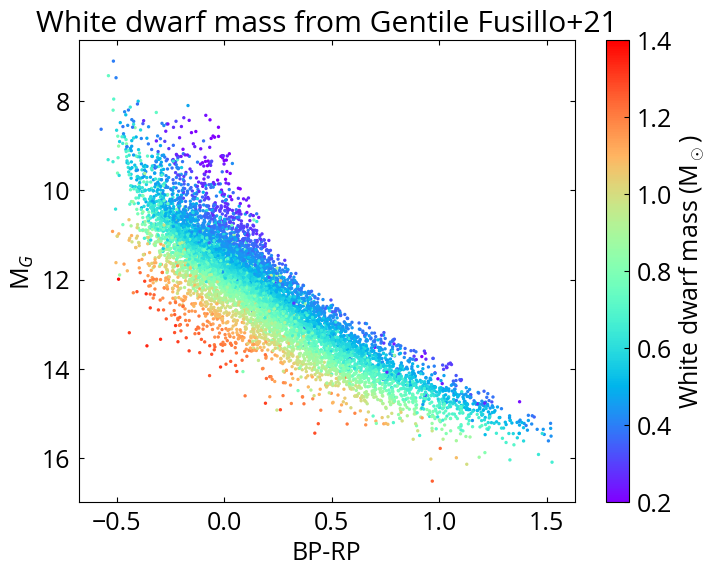

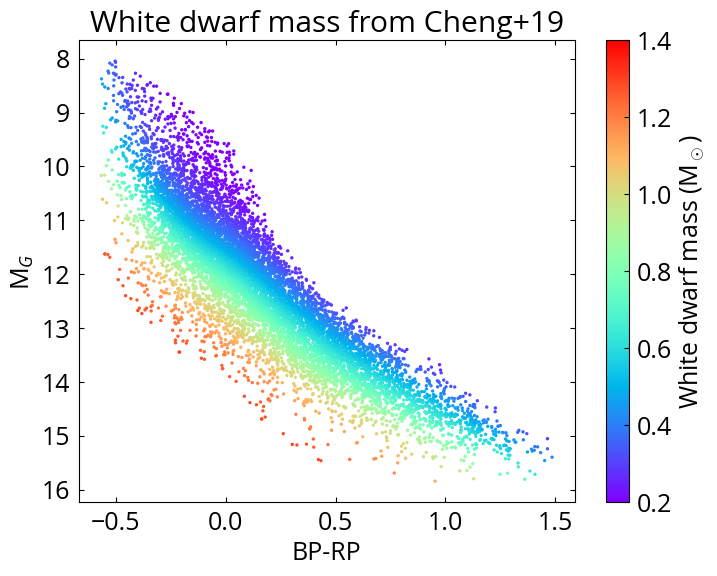

In [9]:
s = (
    (wd_table['Pwd'] > 0.9) *
    (~np.isnan(wd_table['mass_H']))
)
s = np.where(s)[0]
s_random_idx = np.random.choice(s, size=10000)

plt.scatter(
    wd_table['bp_rp'][s_random_idx],
    wd_table['absG'][s_random_idx],
    c=wd_table['mass_H'][s_random_idx],
    cmap='rainbow', s=2, vmax=1.4, vmin=0.2
)
plt.gca().invert_yaxis()

plt.colorbar(label=r'White dwarf mass (M$_\odot$)')
plt.title('White dwarf mass from Gentile Fusillo+21')
plt.xlabel('BP-RP')
plt.ylabel(r'M${_G}$')
plt.show()

s = (
    (wd_table['Pwd'] > 0.9) *
    (~np.isnan(wd_table['mass']))
)
s = np.where(s)[0]
s_random_idx = np.random.choice(s, size=10000)

plt.scatter(
    wd_table['bp_rp'][s_random_idx],
    wd_table['absG'][s_random_idx],
    c=wd_table['mass'][s_random_idx],
    cmap='rainbow', s=2, vmax=1.4, vmin=0.2
)
plt.gca().invert_yaxis()

plt.colorbar(label=r'White dwarf mass (M$_\odot$)')
plt.title('White dwarf mass from Cheng+19')
plt.xlabel('BP-RP')
plt.ylabel(r'M${_G}$')
plt.show()

Load the Gaia EDR3 wide binary catalog (El-Badry+21)

In [11]:
wb_table = Table.read('KE_all_columns_catalog.fits.gz')

In [12]:
wb_table[0:10]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [13]:
#some preparation for wd_table for later table join
wd_table['source_id1'] = wd_table['source_id']
wd_table['source_id2'] = wd_table['source_id']

#compute some relevant quantities for wb_table
wb_table['abs_g1'] = wb_table['phot_g_mean_mag1'] + 5 * np.log10(wb_table['parallax1']) - 10.

wb_table['abs_g2'] = wb_table['phot_g_mean_mag2'] + 5 * np.log10(wb_table['parallax1']) - 10.

wb_table['binary_type1'] = wb_table['binary_type']
wb_table['binary_type2'] = wb_table['binary_type']


wb_table['sep_AU1'] = wb_table['sep_AU']
wb_table['sep_AU2'] = wb_table['sep_AU']

wb_table['R_chance_align1'] = wb_table['R_chance_align']
wb_table['R_chance_align2'] = wb_table['R_chance_align']

wb_table['sep_arcsec1'] = wb_table['pairdistance'] * 3600.
wb_table['sep_arcsec2'] = wb_table['pairdistance'] * 3600.

In [14]:
#make duplicate columns in wb_table to facilitate table join later
cols_to_copy = ['source_id', 'ra', 'dec', 'abs_g', 'bp_rp', 
                'sep_AU', 'sep_arcsec', 'R_chance_align', 'binary_type',
                'phot_g_mean_flux_over_error', 'phot_bp_mean_flux_over_error', 'phot_rp_mean_flux_over_error', 
                'phot_bp_rp_excess_factor', 'ruwe'
               ]

prefix_1 = '1'
prefix_2 = '2'
col_list_1 = ['source_id1']
for col in cols_to_copy:

    wb_table[prefix_1 + 'companion_' + col] = wb_table[col + prefix_2]

    col_list_1.append(prefix_1 + 'companion_' + col)

prefix_1 = '2'
prefix_2 = '1'
col_list_2 = ['source_id2']
for col in cols_to_copy:

    wb_table[prefix_1 + 'companion_' + col] = wb_table[col + prefix_2]

    col_list_2.append(prefix_1 + 'companion_' + col)



In [15]:
#join the white dwarf and wide binary table
#we join twice because the white dwarf can be the primary or secondary of the wide binary
#the final join product is join_table1

#join the case when the white dwarf is the primary in wb_table
join_table = join(wd_table, wb_table[col_list_1], keys='source_id1', join_type='left')

#join the case when the white dwarf is the secondary in wb_table
join_table1 = join(join_table, wb_table[col_list_2], keys='source_id2', join_type='left')


In [16]:
#get correct companion column after join 
t0 = (
    ~join_table1['1companion_source_id'].data.mask
)
np.sum(t0)

t1 = (
    ~join_table1['2companion_source_id'].data.mask
)
np.sum(t1)

for col in cols_to_copy:
    
    join_table1['companion_' + col] = join_table1['1companion_' + col]
    
    join_table1['companion_' + col][t1] = join_table1['2companion_' + col][t1]

In [18]:
join_table1[0:5]

WDJ_name,source_id,dr2_source_id,designation,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,ZP_correction,Pwd,density,solution_id,random_index,ref_epoch,pm,pm_err,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_g_mean_mag_error,phot_g_mean_flux_corrected,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_mag_error,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_mag_error,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,phot_bp_rp_excess_factor_corrected,absG,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,excess_flux_error,bright_N_flag,meanAV,minAV,maxAV,flag_ext,teff_H,eteff_H,logg_H,elogg_H,mass_H,emass_H,chisq_H,teff_He,eteff_He,logg_He,elogg_He,mass_He,emass_He,chisq_He,teff_mixed,eteff_mixed,logg_mixed,elogg_mixed,mass_mixed,emass_mixed,chisq_mixed,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,fidelity_v1,SDSS12,sdss_clean,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,SDSS_separation,SDSS_spec,tot_age,mass,cool_age,source_id1,source_id2,1companion_source_id,1companion_ra,1companion_dec,1companion_abs_g,1companion_bp_rp,1companion_sep_AU,1companion_sep_arcsec,1companion_R_chance_align,1companion_binary_type,1companion_phot_g_mean_flux_over_error,1companion_phot_bp_mean_flux_over_error,1companion_phot_rp_mean_flux_over_error,1companion_phot_bp_rp_excess_factor,1companion_ruwe,2companion_source_id,2companion_ra,2companion_dec,2companion_abs_g,2companion_bp_rp,2companion_sep_AU,2companion_sep_arcsec,2companion_R_chance_align,2companion_binary_type,2companion_phot_g_mean_flux_over_error,2companion_phot_bp_mean_flux_over_error,2companion_phot_rp_mean_flux_over_error,2companion_phot_bp_rp_excess_factor,2companion_ruwe,companion_source_id,companion_ra,companion_dec,companion_abs_g,companion_bp_rp,companion_sep_AU,companion_sep_arcsec,companion_R_chance_align,companion_binary_type,companion_phot_g_mean_flux_over_error,companion_phot_bp_mean_flux_over_error,companion_phot_rp_mean_flux_over_error,companion_phot_bp_rp_excess_factor,companion_ruwe
,,,,deg,mas,deg,mas,mas,mas,,,,,,,yr,mas / yr,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,'electron'.s**-1,'electron'.s**-1,,mag,mag,e-/s,mag,mag,,'electron'.s**-1,'electron'.s**-1,,mag,mag,,'electron'.s**-1,'electron'.s**-1,,mag,mag,,,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,pc,pc,pc,pc,pc,pc,,,,mag,mag

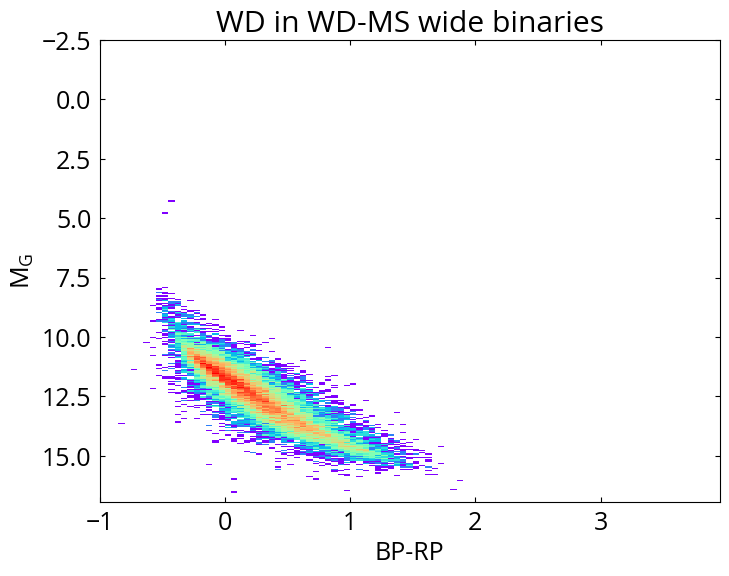

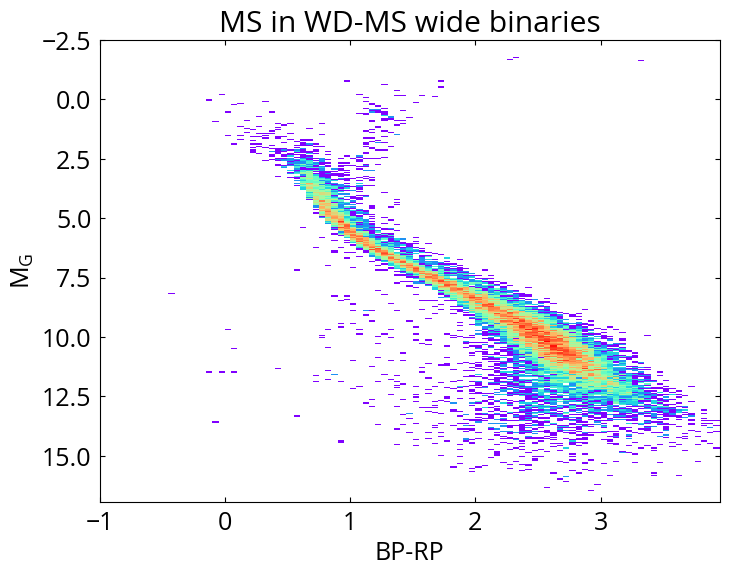

In [20]:
#check the joint result

t = (
    join_table1['companion_binary_type'] == 'WDMS'
)
plt.hist2d(
    join_table1[t]['bp_rp'],
    join_table1[t]['absG'],
    bins=[np.arange(-1, 4, 0.05), np.arange(-2.5, 17., 0.05)],
    norm=LogNorm()
)


plt.gca().invert_yaxis()
plt.title('WD in WD-MS wide binaries')
plt.xlabel('BP-RP')
plt.ylabel(r'M$_{\rm G}$')
plt.show()



plt.hist2d(
    join_table1[t]['companion_bp_rp'],
    join_table1[t]['companion_abs_g'],
    bins=[np.arange(-1, 4, 0.05), np.arange(-2.5, 17., 0.05)],
    norm=LogNorm()
)


plt.gca().invert_yaxis()
plt.title('MS in WD-MS wide binaries')
plt.xlabel('BP-RP')
plt.ylabel(r'M$_{\rm G}$')
plt.show()



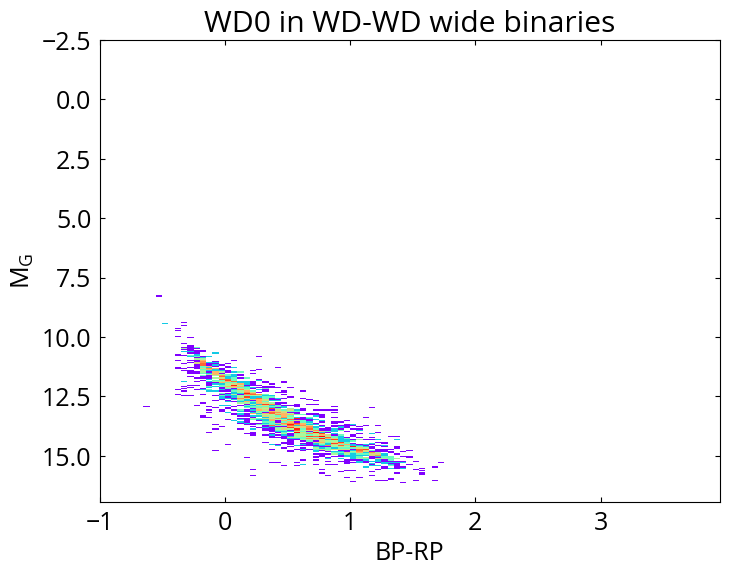

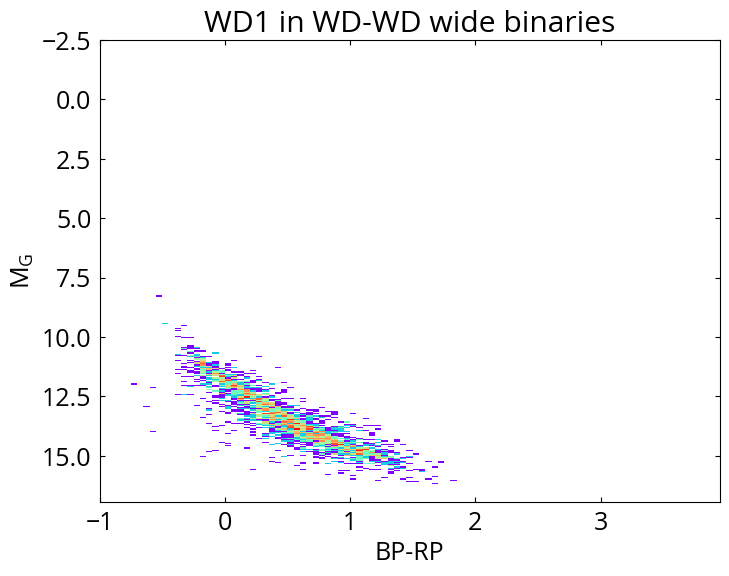

In [21]:
#check the joint result

t = (
    join_table1['companion_binary_type'] == 'WDWD'
)
plt.hist2d(
    join_table1[t]['bp_rp'],
    join_table1[t]['absG'],
    bins=[np.arange(-1, 4, 0.05), np.arange(-2.5, 17., 0.05)],
    norm=LogNorm()
)


plt.gca().invert_yaxis()
plt.title('WD0 in WD-WD wide binaries')
plt.xlabel('BP-RP')
plt.ylabel(r'M$_{\rm G}$')
plt.show()



plt.hist2d(
    join_table1[t]['companion_bp_rp'],
    join_table1[t]['companion_abs_g'],
    bins=[np.arange(-1, 4, 0.05), np.arange(-2.5, 17., 0.05)],
    norm=LogNorm()
)


plt.gca().invert_yaxis()
plt.title('WD1 in WD-WD wide binaries')
plt.xlabel('BP-RP')
plt.ylabel(r'M$_{\rm G}$')
plt.show()



Join table of N_neighbor (number of comoving neighbors) from El-Badry+21

In [25]:
nbs = np.load('../KEB21_codes/neighbor_counts_edr3_all.npz')

nbs_table = Table(
    {
        'source_id': nbs['source_id'],
        'N_neighbors': nbs['N_neighbors']
    }
)

In [26]:
combine_table = join(join_table1, nbs_table, join_type='left', keys='source_id')

In [28]:
#the highest N_neighbors in the white dwarf sample.
#it's in the Milky Way plane (b=-3.6 deg). It will not go into the analysis sample later
np.max(combine_table['N_neighbors'])

2877.0

In [29]:
combine_table.meta = {}
combine_table.write('0_combined_wd_wb_table.fits')